In [ ]:
!pip install swig -q
!pip install gymnasium[box2d] -q
!pip install stable-baselines3 -q
!pip install matplotlib -q

In [17]:
import torch as th
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
import time

In [18]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")


def q_values(model: DQN, obs: np.ndarray) -> np.ndarray:
    obs_tensor = th.tensor(obs, dtype=th.float32, device=device).unsqueeze(0)
    q_values = model.q_net(obs_tensor).cpu().detach().numpy()[0]
    return q_values


def plot_q_values(q_values_list):
    plt.figure(figsize=(10, 6))
    for i in range(len(q_values_list[0])):
        plt.plot([q_values[i] for q_values in q_values_list], label=f'Q{i} Values')
    plt.xlabel('Time')
    plt.ylabel('Q-Values')
    plt.title('Convergence of Q-Values over Time')
    plt.legend()
    plt.show()


def mean_reward(discount_factor):
    env = gym.make("LunarLander-v2").unwrapped
    model = DQN("MlpPolicy", env, verbose=1, gamma=discount_factor, device=device)
    n_eval_episodes = 250

    # Evaluation before training
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, deterministic=True)
    print(f"Before training with discount_factor = {discount_factor}, mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

    start_time = time.time()
    model.learn(total_timesteps=10000, log_interval=100)
    end_time = time.time()

    # Evaluation after training
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, deterministic=True)
    print(f"After training with discount_factor = {discount_factor}, mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

    model.save(f"dqn_lunarlander_{discount_factor}")
    del model
    learn_time = end_time - start_time
    return env, learn_time


def q_values_calculation(discount_factor, env):
    model = DQN.load(f"dqn_lunarlander_{discount_factor}", device=device)
    action_str = ['do nothing', 'left engine', 'main engine', 'right engine']
    q_values_list = []

    obs, info = env.reset()
    for _ in range(500):
        q_val = q_values(model, obs)
        q_values_list.append(q_val)
        action, _states = model.predict(obs, deterministic=True)

        print(f"State Q-values: {q_val}")
        print(f"Action: {action_str[action]}")

        obs, reward, terminated, truncated, info = env.step(action)

    return np.array(q_values_list)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Before training with discount_factor = 0.01, mean_reward: -843.85 +/- 622.11
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.8     |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 6557     |
|    time_elapsed     | 1        |
|    total_timesteps  | 9085     |
----------------------------------
After training with discount_factor = 0.01, mean_reward: -848.27 +/- 637.59
State Q-values: [-0.16975375 -0.11458464  0.03094913 -0.07872255]
Action: main engine
State Q-values: [-0.16841796 -0.11421359  0.0293936  -0.07805346]
Action: main engine
State Q-values: [-0.16801223 -0.11411887  0.02946624 -0.07798314]
Action: main engine
State Q-values: [-0.16738208 -0.11367746  0.02920108 -0.07768292]
Action: main engine
State Q-values: [-0.166

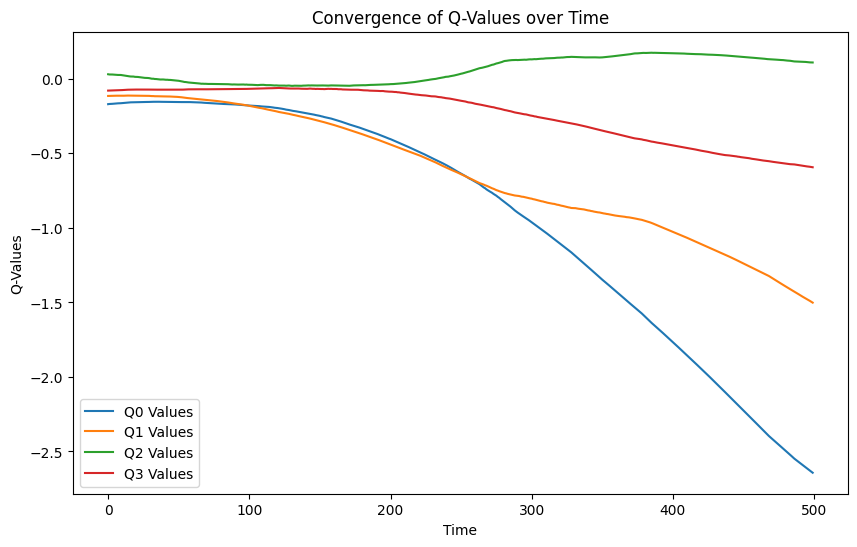

Training time for model with discount_factor = 0.01: 1.544102430343628 seconds.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Before training with discount_factor = 0.5, mean_reward: -291.23 +/- 86.54
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.1     |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 6571     |
|    time_elapsed     | 1        |
|    total_timesteps  | 9506     |
----------------------------------
After training with discount_factor = 0.5, mean_reward: -281.59 +/- 88.93
State Q-values: [0.07714944 0.01644604 0.00588625 0.09265596]
Action: right engine
State Q-values: [0.07759795 0.01746452 0.00569696 0.09250608]
Action: right engine
State Q-values: [0.07816029 0.01870434 0.00539586 0.09228632]
Action: right engine
State Q-values: [0.07881851 0.01960731 0.0

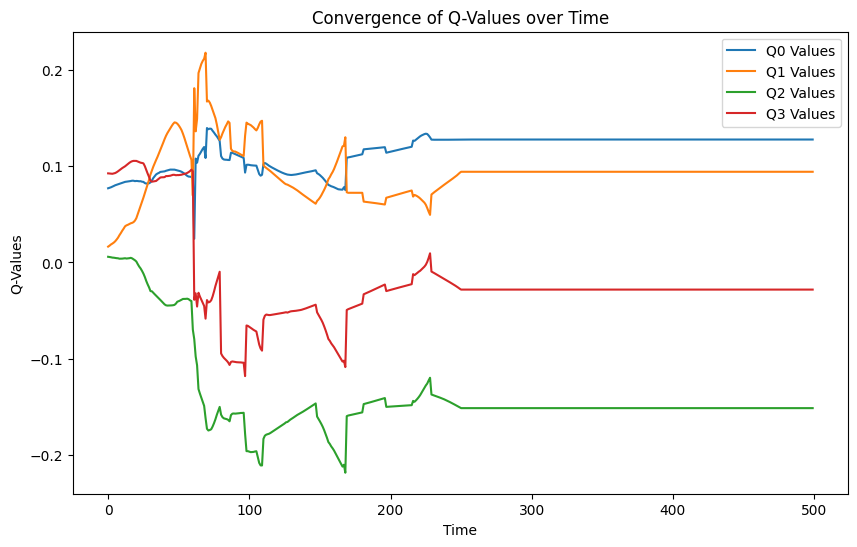

Training time for model with discount_factor = 0.5: 1.532749891281128 seconds.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Before training with discount_factor = 0.99, mean_reward: -563.08 +/- 119.96
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.3     |
|    ep_rew_mean      | -180     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 4370     |
|    time_elapsed     | 2        |
|    total_timesteps  | 9331     |
----------------------------------
After training with discount_factor = 0.99, mean_reward: -546.16 +/- 127.52
State Q-values: [ 0.03525278  0.11761927 -0.09722452  0.01375962]
Action: left engine
State Q-values: [ 0.03346979  0.11596243 -0.09806616  0.01317143]
Action: left engine
State Q-values: [ 0.03139677  0.11394351 -0.09881657  0.01218573]
Action: left engine
State Q-values: [ 0.02940531  

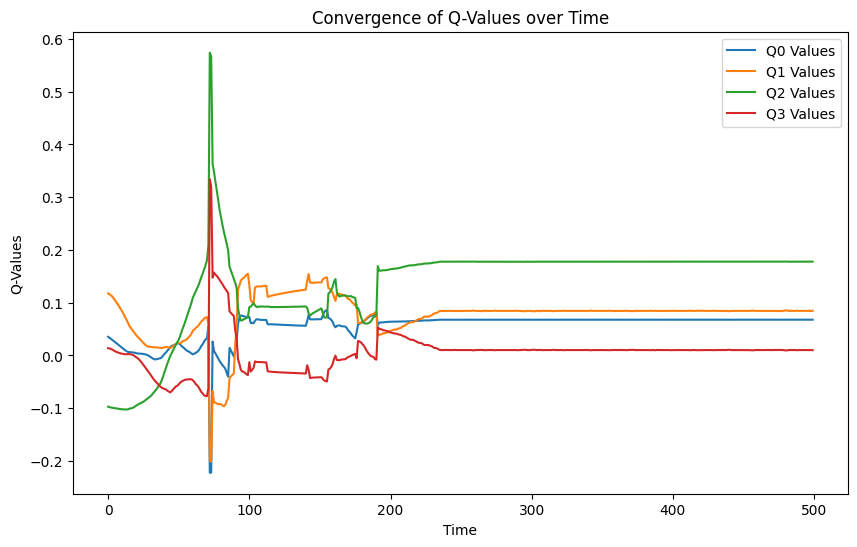

Training time for model with discount_factor = 0.99: 2.3255321979522705 seconds.


In [19]:
discount_factors = [0.01, 0.5, 0.99]

for discount_factor in discount_factors:
    environment, time_to_learn = mean_reward(discount_factor)
    q_vals = q_values_calculation(discount_factor, environment)
    plot_q_values(q_vals)
    print(f'Training time for model with discount_factor = {discount_factor}: {time_to_learn} seconds.')
    environment.close()